# MultiNorm

This is a tutorial notebook for the ``MultiNorm`` class from the ``multinorm`` Python package ([Github](https://github.com/cdeil/multinorm)).

- A quick tutorial introduction (~ 10 min read)
- Explain and illustrate some of the theory / statistical aspects
- Hands-on introduction how to work with ``MultiNorm`` class.

Suggestions:

- Read this tutorial and judge if `multinorm` is useful for you.
- If yes, install it with `pip install multinorm`, download this notebook, and execute / play with these examples on your machine.
- Learn more at https://multinorm.readthedocs.io (complete description of features and theory).

We will use [pandas](http://pandas.pydata.org), so after reading this you will be a data scientist!
In the future we will probably change the example model to a deep neural network and use [tensorflow](https://www.tensorflow.org/), because likelihood fitting is so 1990s.

## Introduction

- TODO: What is MVN (theory)?
- https://en.wikipedia.org/wiki/Multivariate_normal_distribution
- TODO: What is `MultiNorm` (code)?


We will be using [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit a model to data and obtain an example covariance matrix. Note that most analysis problems are not a simple least squares curve fit, but involve custom data and likelihood. Information how to obtain parameter error and covariance estimates with other popular Python packages is described in the `multinorm` documentation.

## Imports

Let's start by importing everything we'll use in this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
from multinorm import MultiNorm

## Example Setup

As mentioned in the introduction, the kind of analysis we are considering here is that there is a **model** with **parameters**, as well as some **data** and a **likelihood function**. 

We will use the [Rat42](https://www.itl.nist.gov/div898/strd/nls/data/ratkowsky2.shtml) dataset from the [NIST Standard Reference Database](https://www.itl.nist.gov/div898/strd/). To quote from [here](https://www.itl.nist.gov/div898/strd/nls/data/LINKS/i-ratkowsky2.shtml):

> This model and data are an example of fitting sigmoidal growth curves taken from Ratkowsky (1983).
> The response variable is pasture yield, and the predictor variable is growing time.

Did I hear you say

> Why? pasture yield? WTF?

Well, the data is small (9 observations x, y) and , and the model is simple (one line in Python) and has 3 parameters, which is nice to illustrate properties of the correlation matrix and multivariate normal distribution. And the fit is using a least square likelihood, which is built-in in `scipy` and available for pretty much any fitting package, or can be implemented also with one line in Python.

In [2]:
data = pd.DataFrame({
    'x': [9, 14, 21, 28, 42, 57, 63, 70, 79],
    'y': [8.93, 10.80, 18.59, 22.33, 39.35, 56.11, 61.73, 64.62, 67.08],
})
data.T

,0,1,2,3,4,5,6,7,8
x,9.00,14.0,21.00,28.00,42.00,57.00,63.00,70.00,79.00
y,8.93,10.8,18.59,22.33,39.35,56.11,61.73,64.62,67.08


And having a DOI (http://dx.doi.org/10.18434/T43G6C) and expected reference results for the analysis is also nice. This is the result we should find:

In [3]:
expected = pd.DataFrame.from_records(
    [
        ("b1", 7.2462237576e01, 1.7340283401e00),
        ("b2", 2.6180768402e00, 8.8295217536e-02),
        ("b3", 6.7359200066e-02, 3.4465663377e-03),
    ],
    columns=["par", "value", "error"],
    index='par',
)
expected

,value,error
par,,
b1,72.462238,1.734028
b2,2.618077,0.088295
b3,0.067359,0.003447


### Model

Our model is just a simple line.

In [4]:
def model(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 - b3 *x))

### Fit

If we fit the model to the data, we obtain a parameter estimate (`popt`, the "optimial" or "best" parameter values) and a covariance matrix (`pcov`).

In [5]:
p0 = (100, 1, 0.1)
popt, pcov = scipy.optimize.curve_fit(
    f=model,
    xdata=data["x"],
    ydata=data["y"],
    p0=p0,
)

Let's make a plot to see the best-fit model and the data:

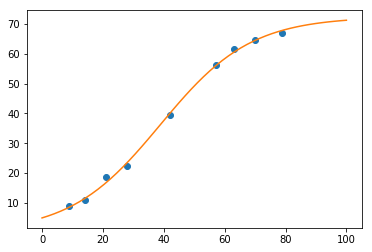

In [6]:
plt.plot(data['x'], data["y"], 'o')
x = np.linspace(0, 100)
plt.plot(x, model(x, *popt));

Finally, this is where `MultiNorm` comes in!

## MultiNorm

In the last section we fit our model `y = m x + b` with two parameters `(m, b)` to some data, and optained the best-fit parameter vector `popt` and a covariance matrix `pcov`. Using this information, we can create a `MultiNorm` object.

### Create

In [7]:
from multinorm import MultiNorm

In [8]:
mn = MultiNorm(mean=popt, cov=pcov, names=["b1", "b2", "b3"])

In [9]:
mn

MultiNorm with n=3 parameters:
           mean       error
name                     
b1    72.462232  1.734039
b2     2.618077  0.088295
b3     0.067359  0.003447

`MultiNorm` is very simple, it just stores the `mean` vector and `cov` matrix
and exposes them as pandas Series and DataFrame objects, with `name` as index.

Of course the `mean` and `cov` are still available as Numpy arrays, using the `.values` property of the pandas objects.

In [10]:
mn.names

['b1', 'b2', 'b3']

In [11]:
mn.mean

name
b1    72.462232
b2     2.618077
b3     0.067359
Name: mean, dtype: float64

In [12]:
mn.cov

name,b1,b2,b3
name,,,
b1,3.006892,-0.069747,-0.005014
b2,-0.069747,0.007796,0.000250
b3,-0.005014,0.000250,0.000012


### Errors

In the printout of `mn` above, we saw that in addition to the `names`, `mean` and `cov` we passed in, another property `error` exists.

This is the vector of "1 sigma" parameter error estimates:

In [13]:
mn.error

name
b1    1.734039
b2    0.088295
b3    0.003447
Name: error, dtype: float64

Usually you would state your measurement giving the estimated value and error for each parameter:
- `b1 = 72.46 +/- 1.73`
- `b2 = 2.618 +/- 0.088`
- `b3 = 0.0673 +/- 0.0034`

The relationship between the covariance matrix and the errors is very simple: the diagonal entries of the covariance matrix contains the errors squared, meaning that you can compute the errors as the square root of the diagonal entries:

In [14]:
np.sqrt(pcov.diagonal())

array([1.73403926, 0.08829495, 0.00344656])

### Parameters

Possibly the property you'll use most is `parameters`, which is a `pandas.DataFrame` with `name` as index, and columns that contain `mean` and `error` for all parameters. It has a nice table printout, and you can use the common pandas methods to select rows and columns and entries.

In [15]:
mn.parameters

,mean,error
name,,
b1,72.462232,1.734039
b2,2.618077,0.088295
b3,0.067359,0.003447


In [16]:
pars = mn.parameters
# Access parameter info as Series by index or name
pars.iloc[0]
pars.loc["b1"]
# All the power of pandas at your fingertip
# Just as an example:
pars["mean"].to_frame().T

name,b1,b2,b3
mean,72.462232,2.618077,0.067359


### Correlations

tbd

In [17]:
mn.correlation

name,b1,b2,b3
name,,,
b1,1.000000,-0.455547,-0.838906
b2,-0.455547,1.000000,0.821333
b3,-0.838906,0.821333,1.000000


In [18]:
mn.correlation.loc["b1", "b3"]

-0.8389061143534849

In [19]:
mn.correlation["b3"].to_frame()

,b3
name,
b1,-0.838906
b2,0.821333
b3,1.000000


### Plot

TODO: plotting ellipses with MPL is horrible. Add a plot helper method!

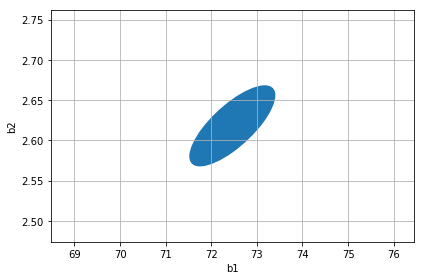

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ellipse = mn.fix("b3").to_matplotlib_ellipse()
ax.add_artist(ellipse)
ax.set_xlabel("b1")
ax.set_ylabel("b2")
# ax.set_xlim(7, 13)
# ax.set_ylim(17, 23)
ax.grid(True)

plt.plot(mn.mean["b1"], mn.mean["b2"])
plt.tight_layout()

plt.show()

## Summary

Let us recap the most important points concerning multivariante normal distributions and the `MultiNorm` class.

To learn more: https://multinorm.readthedocs.io

### Theory

- TODO: MVN are ...

### Code

- TODO: the `MultiNorm` class ...

## Exercises

- TODO